In [ ]:
#import the necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [ ]:
#load the data
data = pd.read_csv("/content/NSSO_68.csv", low_memory=False)

In [ ]:
#display the data
display(data)

,slno,grp,Round_Centre,FSU_number,Round,Schedule_Number,Sample,Sector,state,State_Region,...,pickle_v,sauce_jam_v,Othrprocessed_v,Beveragestotal_v,foodtotal_v,foodtotal_q,state_1,Region,fruits_df_tt_v,fv_tot
0,1,4.100000e+31,1,41000,68,10,1,2,24,242,...,0.0,0.000,0.0,0.000000,1141.492400,30.942394,GUJ,2.0,12.000000,154.180000
1,2,4.100000e+31,1,41000,68,10,1,2,24,242,...,0.0,0.000,0.0,17.500000,1244.553500,29.286153,GUJ,2.0,333.000000,484.950000
2,3,4.100000e+31,1,41000,68,10,1,2,24,242,...,0.0,0.000,0.0,0.000000,1050.315400,31.527046,GUJ,2.0,35.000000,214.840000
3,4,4.100000e+31,1,41000,68,10,1,2,24,242,...,0.0,0.000,0.0,33.333333,1142.591667,27.834607,GUJ,2.0,168.333333,302.300000
4,5,4.100000e+31,1,41000,68,10,1,2,24,242,...,0.0,0.000,0.0,75.000000,945.249500,27.600713,GUJ,2.0,15.000000,148.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15498,15499,4.430000e+31,1,44260,68,10,1,2,16,161,...,0.0,0.000,0.0,3.333333,392.686000,18.366902,TRPR,1.0,9.000000,102.666667
15499,15500,4.430000e+31,1,44260,68,10,1,2,16,161,...,0.0,0.000,0.0,2.500000,348.858125,17.237648,TRPR,1.0,4.375000,58.125000
15500,15501,4.430000e+31,1,44260,68,10,1,2,16,161,...,0.0,0.000,0.0,2.647059,292.321529,15.229551,TRPR,1.0,1.470588,34.958824
15501,15502,4.430000e+31,1,44261,68,10,1,2,16,161,...,0.0,0.016,0.0,136.682667,1777.097667,38.333900,TRPR,1.0,2.666667,204.333333


In [ ]:
#Filter the data for West Bengal (WB)
WB_data = data[data["state_1"] == "WB"]

In [ ]:
#Check for missing values
missing_values = WB_data.isna().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


In [ ]:
WB = WB_data[['state_1', 'District', 'Region', 'Sector', 'State_Region', 'Meals_At_Home', 'ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q', 'No_of_Meals_per_day']]

In [ ]:
#impute missing values with mean
def impute_with_mean(column):
    if column.hasnans:
        column.fillna(column.mean(), inplace=True)
    return column

In [ ]:
WB['Meals_At_Home'] = impute_with_mean(WB['Meals_At_Home'])

<ipython-input-12-6145f5b4cff1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.fillna(column.mean(), inplace=True)
<ipython-input-13-9cc784c92b5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WB['Meals_At_Home'] = impute_with_mean(WB['Meals_At_Home'])


In [ ]:
#removing outliers
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - (1.5 * IQR)
    upper_threshold = Q3 + (1.5 * IQR)
    df = df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    return df

outlier_columns = ['ricepds_v', 'chicken_q']
for col in outlier_columns:
    WB = remove_outliers(WB, col)

In [ ]:
#total consumption
WB['total_consumption'] = WB[['ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q']].sum(axis=1)

In [ ]:
def summarize_consumption(group_col):
    summary = WB.groupby(group_col)['total_consumption'].sum().reset_index()
    summary.sort_values(by='total_consumption', ascending=False, inplace=True)
    return summary

In [ ]:
district_summary = summarize_consumption('District')
region_summary = summarize_consumption('Region')

In [ ]:
print("Top Consuming Districts:")
print(district_summary.head(4))
print("Region Consumption Summary:")
print(region_summary)

Top Consuming Districts:
    District  total_consumption
10        11         538.476429
16        17         413.168828
15        16         343.602502
17        18         130.354167
Region Consumption Summary:
   Region  total_consumption
2     3.0        1081.999423
3     4.0         508.351708
1     2.0         457.891140
0     1.0         168.240909
4     5.0         106.387202


In [25]:
#Renaming districts and sectors
district_mapping = {"1" : "Darjiling", "2" : "Jalpaiguri", "3" : "Koch Bihar", "4" : "Uttar Dinajpur", "5" : "Dakshin Dinajpur *", "6" : "Maldah", "7" : "Murshidabad", "8" : "Birbhum", "9" : "Barddhaman", "10" : "Nadia", "11" : "North Twenty Four Parganas", "12" : "Hugli", "13" : "Bankura", "14" : "Puruliya", "15" : "Pashim Midnapur", "16" : "Haora","17" : "Kolkata", "18" : "South  Twenty Four Parganas", "19" : "Purba Midnapur"}
sector_mapping = {"1": "RURAL", "2": "URBAN"}

In [26]:
WB['District'] = WB['District'].astype(str)
WB['Sector'] = WB['Sector'].astype(str)

WB['District'] = WB['District'].map(district_mapping).fillna(WB['District'])
WB['Sector'] = WB['Sector'].map(sector_mapping).fillna(WB['Sector'])

In [27]:
print(WB.head())

     state_1     District  Region Sector  State_Region  Meals_At_Home  \
6218      WB  Murshidabad     2.0  URBAN           192           90.0   
6219      WB  Murshidabad     2.0  URBAN           192           60.0   
6220      WB  Murshidabad     2.0  URBAN           192           60.0   
6221      WB  Murshidabad     2.0  URBAN           192           60.0   
6222      WB  Murshidabad     2.0  URBAN           192           90.0   

      ricepds_v  Wheatpds_q  chicken_q  pulsep_q  wheatos_q  \
6218        0.0         0.0   0.750000  0.125000   3.500000   
6219        0.0         0.0   0.214286  0.014286   2.285714   
6220        0.0         0.0   0.000000  0.025000   1.250000   
6221        0.0         0.0   0.000000  0.000000   1.666667   
6222        0.0         0.0   0.000000  0.000000   3.866667   

      No_of_Meals_per_day  total_consumption  
6218                  3.0           4.375000  
6219                  2.0           2.514286  
6220                  2.0           1.275

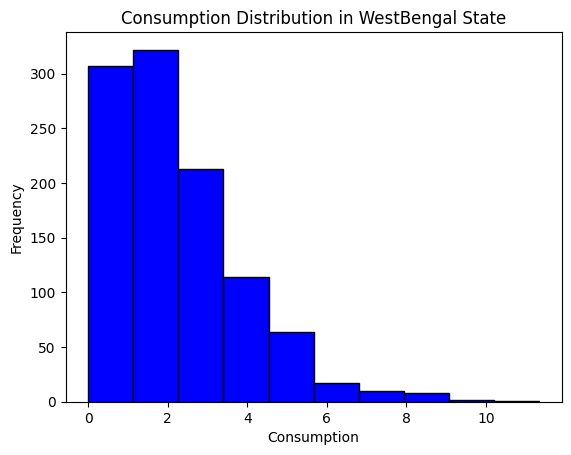

In [28]:
plt.hist(WB['total_consumption'], bins=10, color='blue', edgecolor='black')
plt.xlabel("Consumption")
plt.ylabel("Frequency")
plt.title("Consumption Distribution in WestBengal State")
plt.show()

In [30]:
WB_consumption = WB.groupby('District')['total_consumption'].sum().reset_index()

In [31]:
print(WB_consumption.head())

             District  total_consumption
0             Bankura          22.789583
1          Barddhaman          64.707183
2             Birbhum          95.138889
3  Dakshin Dinajpur *          43.978571
4           Darjiling          74.724242


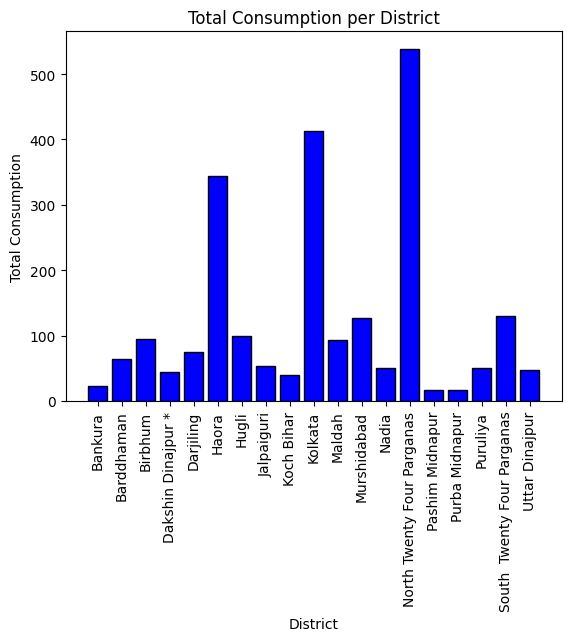

In [32]:
plt.bar(WB_consumption['District'], WB_consumption['total_consumption'], color='blue', edgecolor='black')
plt.xlabel("District")
plt.ylabel("Total Consumption")
plt.title("Total Consumption per District")
plt.xticks(rotation=90)  # Rotate district names for better visibility
plt.show()

In [33]:
#west bengal's shape file based on total consumption per district
data_map = gpd.read_file("/content/WEST BENGAL_DISTRICTS.geojson")

In [59]:
print(data_map.columns)
print(WB_consumption.columns)

Index(['District', 'stname', 'stcode11', 'dtcode11', 'year_stat',
       'Shape_Length', 'Shape_Area', 'OBJECTID', 'test', 'Dist_LGD',
       'State_LGD', 'geometry'],
      dtype='object')
Index(['slno', 'grp', 'Round_Centre', 'FSU_number', 'Round', 'Schedule_Number',
       'Sample', 'Sector', 'state', 'State_Region',
       ...
       'pickle_v', 'sauce_jam_v', 'Othrprocessed_v', 'Beveragestotal_v',
       'foodtotal_v', 'foodtotal_q', 'state_1', 'Region', 'fruits_df_tt_v',
       'fv_tot'],
      dtype='object', length=384)


In [99]:
data_map_data = data_map.merge(WB_consumption, left_on='dtname', right_on='District')

In [100]:
data_map['District'] = WB_consumption['District']

In [101]:
print(data_map.columns)

Index(['dtname', 'total_consumption', 'stcode11', 'dtcode11', 'year_stat',
       'Shape_Length', 'Shape_Area', 'OBJECTID', 'test', 'Dist_LGD',
       'State_LGD', 'geometry', 'District'],
      dtype='object')


In [102]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
data_map = gpd.read_file("/content/WEST BENGAL_DISTRICTS.geojson")

In [104]:
data_map = data_map.rename(columns={'dtname': 'District'})

In [105]:
display(data_map.rename)

<bound method DataFrame.rename of                      District       stname stcode11 dtcode11 year_stat  \
0   South Twenty Four Pargan*  WEST BENGAL       19      343    2011_c   
1                   Darjiling  WEST BENGAL       19      327    2011_c   
2                  Jalpaiguri  WEST BENGAL       19      328    2011_c   
3            Dakshin Dinajpur  WEST BENGAL       19      331    2011_c   
4                      Maldah  WEST BENGAL       19      332    2011_c   
5                 Murshidabad  WEST BENGAL       19      333    2011_c   
6                     Birbhum  WEST BENGAL       19      334    2011_c   
7                       Nadia  WEST BENGAL       19      336    2011_c   
8             Purba Bardhaman  WEST BENGAL       19      335    2011_c   
9                    Puruliya  WEST BENGAL       19      340    2011_c   
10                    Bankura  WEST BENGAL       19      339    2011_c   
11  North Twenty Four Pargan*  WEST BENGAL       19      337    2011_c   
12                    Hooghly  WEST BENGAL       19      338    2011_c   
13             Medinipur West  WEST BENGAL       19      344    2011_c   
14                     Howrah  WEST BENGAL       19      341    2011_c   
15                    Kolkata  WEST BENGAL       19      342    2011_c   
16            Purba Medinipur  WEST BENGAL       19      345    2011_c   
17                 Alipurduar  WEST BENGAL       19      774    2014_c   
18          Paschim Bardhaman  WEST BENGAL       19      777    2017_c   
19                  Kalimpong  WEST BENGAL       19      775    2017_c   
20                   Jhargram  WEST BENGAL       19      776    2017_c   
21                Cooch Behar  WEST BENGAL       19      329    2011_c   
22             Uttar Dinajpur  WEST BENGAL       19      330    2011_c   

    Shape_Length    Shape_Area  OBJECTID  test  Dist_LGD  State_LGD  \
0   2.860637e+06  8.796820e+09       165     0       304         19   
1   3.711838e+05  2.563482e+09       265     0       309         19   
2   5.019763e+05  4.274422e+09       273     0       314         19   
3   4.310810e+05  2.751830e+09       347     1       310         19   
4   5.314818e+05  4.398954e+09       348     1       316         19   
5   6.540053e+05  6.591378e+09       384     1       319         19   
6   7.437208e+05  5.465723e+09       396     1       307         19   
7   7.606131e+05  4.670038e+09       413     1       320         19   
8   6.322263e+05  6.449898e+09       426     0       306         19   
9   6.497435e+05  7.437097e+09       434     0       321         19   
10  5.563543e+05  8.187904e+09       437     0       305         19   
11  6.380735e+05  4.734497e+09       446     0       303         19   
12  5.587373e+05  3.714099e+09       448     0       312         19   
13  6.177002e+05  7.377313e+09       458     0       318         19   
14  2.767141e+05  1.706318e+09       463     0       313         19   
15  6.971643e+04  1.161811e+08       467     0       315         19   
16  4.421171e+05  4.637089e+09       470     0       317         19   
17  3.749512e+05  3.455633e+09       570     0       664         19   
18  2.831539e+05  1.923796e+09       571     0       704         19   
19  1.938661e+05  1.372158e+09       572     0       702         19   
20  5.375262e+05  3.637798e+09       573     0       703         19   
21  1.047307e+06  4.225582e+09       575     0       308         19   
22  8.048877e+05  3.848814e+09       576     0       311         19   

                                             geometry  
0   MULTIPOLYGON (((88.05099 21.50899, 88.05210 21...  
1   POLYGON ((88.04002 27.22062, 88.03649 27.22107...  
2   POLYGON ((88.92027 26.99427, 88.91728 26.99809...  
3   POLYGON ((88.40204 25.60814, 88.40201 25.60814...  
4   POLYGON ((87.95961 25.53857, 87.95916 25.53873...  
5   POLYGON ((87.89765 24.85942, 87.89720 24.86047...  
6   POLYGON ((87.79303 24.58363, 87.79204 24.58400...  
7   POLYGON ((88.72420 24.10433, 88.

In [106]:
WB_consumption = pd.read_csv("/content/NSSO_68.csv", low_memory=False)

In [107]:
WB_consumption = WB.groupby('District')['total_consumption'].sum().reset_index()

In [108]:
print(WB_consumption.head())

             District  total_consumption
0             Bankura          22.789583
1          Barddhaman          64.707183
2             Birbhum          95.138889
3  Dakshin Dinajpur *          43.978571
4           Darjiling          74.724242


In [109]:
data_map = gpd.read_file("/content/WEST BENGAL_DISTRICTS.geojson")
data_map = data_map.rename(columns={'dtname': 'total_consumption'})

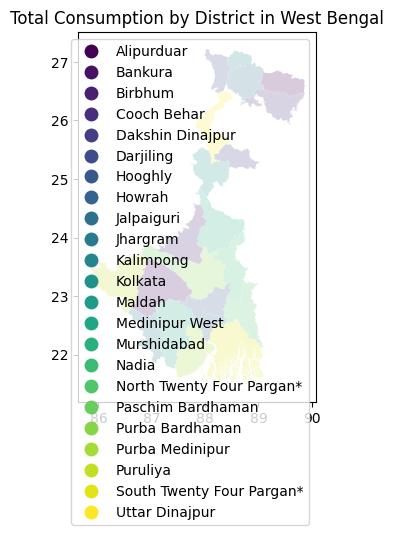

In [110]:
fig, ax = plt.subplots(1, 1)
data_map.plot(column='total_consumption', cmap='viridis', legend=True, ax=ax)
ax.set_title('Total Consumption by District in West Bengal')
plt.show()